In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy.ma as ma

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/archie/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
def distance(data):
    distances = pd.DataFrame()    
    # calculate distance in km between points
    data['dx'] = np.insert(sw.distance(data['Lon'].values, data['Lat'].values, 0),0,0)/1000
    data['x'] = np.cumsum(data['dx'])

    return data  

def bin(pgram, periods, bins, bin_mid):
    
    y = periods
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
          
    z = pgram # bead attribute

    digitized = np.digitize(y, bins)
    bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

    bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
    bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
    binned['var'] = bin_means
    binned['std'] = bin_std

    return binned


In [3]:
# import data

maxlon = 171
minlon = 130

Tok1 = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)-1000
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]
Tok1 = distance(Tok1).reset_index(drop = True)


Tok2 = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Tokyo2_vSept16.csv', sep = ',')
Tok2['density'] = sw.rho(Tok2['S'].values,Tok2['T'].values,0)-1000

Tok3 = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)-1000
Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tok3f = pd.read_csv(r'../data/filtered_O2Ar/Tokyo3_filt_vOct17.csv',sep=',')
Tok3f['density'] = sw.rho(Tok3f['S'].values,Tok3f['T'].values,0)-1000
Tok3f = Tok3f[(Tok3f['Lon']>minlon) & (Tok3f['Lon']<maxlon)]

Tian = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)-1000
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]
Tian = distance(Tian).reset_index(drop = True)


print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density', u'dx', u'x'],
      dtype='object')


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/archie/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


estimated calibration slope =  0.646943498049 , r =  0.809240679627 , p-value < 0.05  True


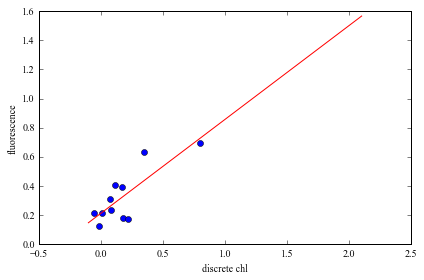

In [4]:
# import calibration data

calib = pd.read_csv(r'/Users/archie/Google Drive/o2ar_data/Discrete_ChlO2Ar_ForSophie.csv', sep = ',')

calib = calib.dropna()
#calib = calib[(calib['Lon']>minlon) & (calib['Lon']<maxlon)]

subTok1 = calib[calib['Cruise ID']=='Tokyo_1']
subTok1['Fluo'] = np.interp(subTok1['Date/Time'],Tok1['Timestamp'], Tok1['Fluo'],left=np.nan, right=np.nan, period=None)
subTok1 = subTok1.dropna()

plt.plot(subTok1['Fluo'],subTok1['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok1['Fluo'],subTok1['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

# calibrate fluorescence for Tokyo_1

Tok1['chl'] = mT*Tok1['Fluo']+cT

# Tok1.to_csv('../data/Tokyo1_chl.csv', sep = ',')

estimated calibration slope =  -72.4725371974 , r =  -0.0508311264577 , p-value < 0.05  False


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


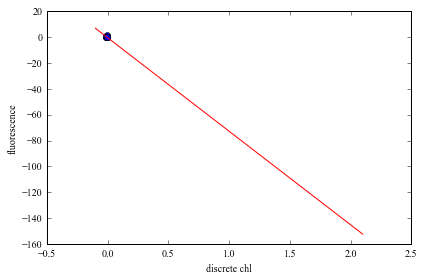

In [5]:
subTok2 = calib[calib['Cruise ID']=='Tokyo_2']
subTok2['Fluo'] = np.interp(subTok2['Date/Time'],Tok2['Timestamp'], Tok2['Fluo'],left=np.nan, right=np.nan, period=None)
subTok2 = subTok2.dropna()

plt.plot(subTok2['Fluo'],subTok2['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok2['Fluo'],subTok2['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

# calibrate fluorescence for Tokyo_1

Tok2['chl'] = mT*Tok2['Fluo']+cT

# Tok2.to_csv('../data/Tokyo2_chl.csv', sep = ',')

estimated calibration slope =  0.254173244581 , r =  0.746429220644 , p-value < 0.05  True


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


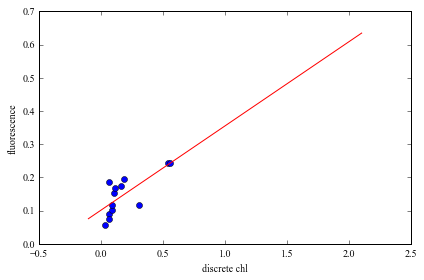

In [6]:
# import calibration data
subTok3 = calib[calib['Cruise ID']=='Tokyo_3']
subTok3['Fluo'] = np.interp(subTok3['Date/Time'],Tok3['Timestamp'], Tok3['Fluo'],left=np.nan, right=np.nan, period=None)
subTok3 = subTok3.dropna()

plt.plot(subTok3['Fluo'], subTok3['[Chl] (ug/L)'], 'o')
plt.xlabel('discrete chl')
plt.ylabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subTok3['Fluo'], subTok3['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2,0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

Tok3['chl'] = mT*Tok3['Fluo']+cT

# Tok3.to_csv('../data/Tokyo3_chl.csv', sep = ',')

estimated calibration slope =  0.503576898909 , r =  0.92078143778 , p-value < 0.05  True


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


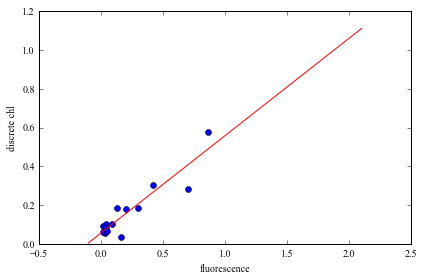

In [7]:
# import calibration data


subT = calib[calib['Cruise ID']=='Tianjin_2']
subT['Fluo'] = np.interp(subT['Date/Time'],Tian['Timestamp'], Tian['Fluo'], left=np.nan, right=np.nan, period=None)
subT = subT.dropna()

plt.plot(subT['Fluo'], subT['[Chl] (ug/L)'],'o')
plt.ylabel('discrete chl')
plt.xlabel('fluorescence')

mT,cT, rT, pT, std_errT = ss.linregress(subT['Fluo'], subT['[Chl] (ug/L)'])
plt.plot(np.arange(-0.1, 2.2, 0.1), mT*(np.arange(-0.1, 2.2, 0.1))+cT, 'r')

print 'estimated calibration slope = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05

plt.show()

Tian['chl'] = mT*Tian['Fluo']+cT

# Tian.to_csv('../data/Tian_chl.csv', sep = ',')

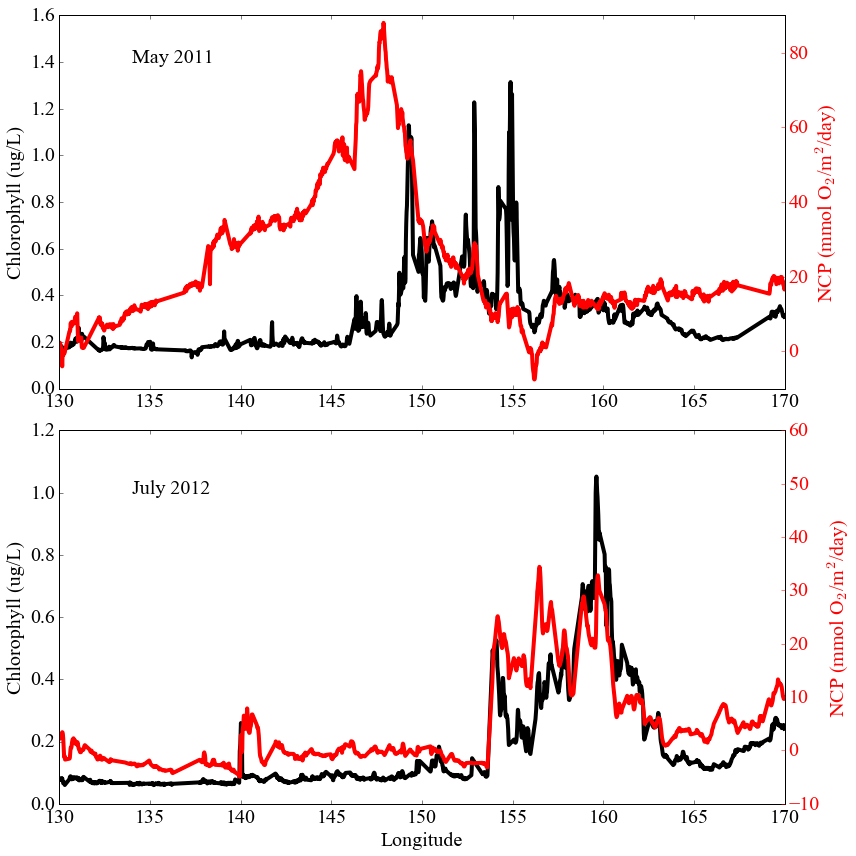

In [8]:
# fig2, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12, 18), dpi = 300)
fig2, (ax1, ax4) = plt.subplots(2, 1, figsize = (12, 12), dpi = 600)

nn = 4

ax1.plot(Tok1['Lon'], Tok1['chl'], '-k', lw = nn)
ax8 = ax1.twinx()
ax8.plot(Tok1['Lon'], Tok1['Air-sea flux'], '-r', lw = nn)
ax1.set_xlim([130, 170])
ax1.set_ylim([0, 1.6])
ax8.set_ylim([-10, 90])
ax1.text(134, 1.4,'May 2011', fontsize = 20)

ax1.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 20)
ax8.set_ylabel('NCP (mmol O$_2$/m$^{2}$/day)', color= 'r', fontsize = 20)
ax8.tick_params(colors='r', labelsize = 20)
ax1.tick_params(colors='k', labelsize = 20)
# ax1.axvline(146, color='grey', lw =3)

# ax2.plot(Tok2['Lon'], Tok2['chl'], '.k')
# ax5 = ax2.twinx()
# ax5.plot(Tok2['Lon'], Tok2['Air-sea flux'], '.r')
# ax2.set_xlim([130, 170])
# ax2.set_ylim([0, 1.75])
# ax5.set_ylim([-20, 80])
# ax2.text(132, 1.5,'July 2011', fontsize = 14)

# ax2.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 14)
# ax5.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
# ax5.tick_params(colors='r')

# ax3.plot(Tok3['Lon'], Tok3['chl'], '.k')
# ax6 = ax3.twinx()
# ax6.plot(Tok3['Lon'], Tok3['Air-sea flux'], '.r')
# ax3.set_xlim([130, 170])
# ax3.set_ylim([0, 1.75])
# ax6.set_ylim([-20, 80])
# ax3.text(132, 1.5,'September 2011', fontsize = 14)

# ax3.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 14)
# ax6.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
# ax6.tick_params(colors='r')

ax4.plot(Tian['Lon'], Tian['chl'], '-k', lw = nn)
ax7 = ax4.twinx()
ax7.plot(Tian['Lon'], Tian['Air-sea flux'], '-r', lw = nn)
ax4.set_xlim([130, 170])
ax4.set_ylim([0, 1.2])
ax7.set_ylim([-10, 60])
ax4.text(134, 1.0,'July 2012', fontsize = 20)

ax4.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 20)
ax7.set_ylabel('NCP (mmol O$_2$/m$^{2}$/day)', color= 'r', fontsize = 20)
ax7.tick_params(colors='r', labelsize = 20)
ax4.tick_params(colors='k', labelsize = 20)
ax4.set_xlabel('Longitude', fontsize = 20)

# ax7.axvline(153, color='grey', lw =3)
# ax7.axvline(164, color='grey', lw =3)

plt.show()

# fig2.savefig('../figures/uway_NCP_Chl_MayJuly.png', dpi = 300)

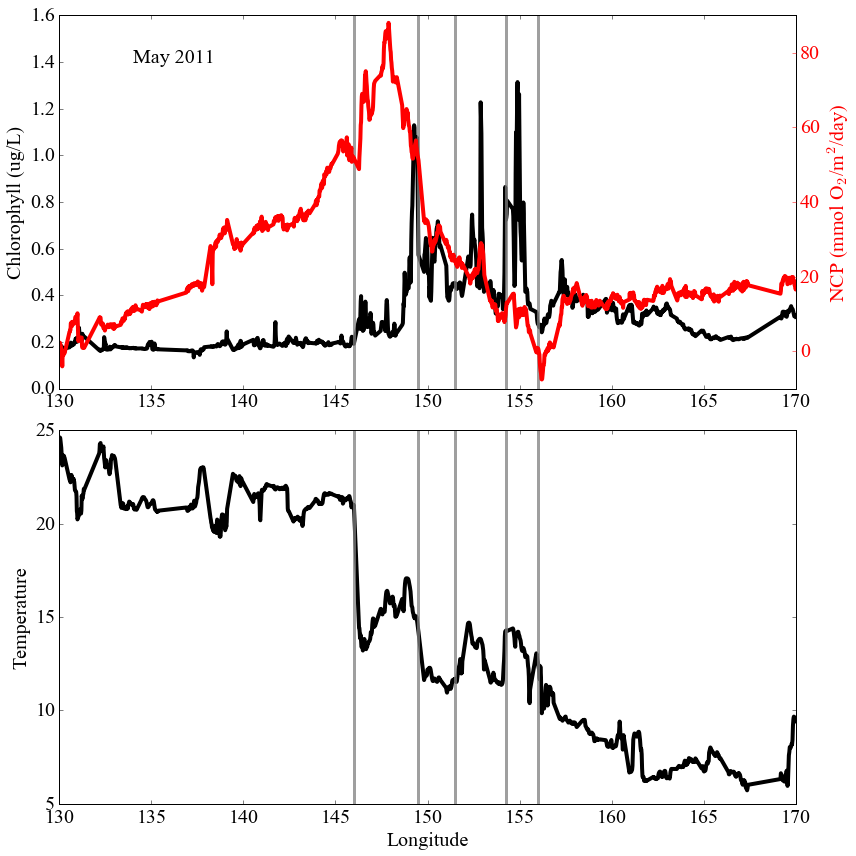

In [9]:
# fig2, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12, 18), dpi = 300)
fig2, (ax1, ax4) = plt.subplots(2, 1, figsize = (12, 12), dpi = 600)

nn = 4

ax1.plot(Tok1['Lon'], Tok1['chl'], '-k', lw = nn)
ax8 = ax1.twinx()
ax8.plot(Tok1['Lon'], Tok1['Air-sea flux'], '-r', lw = nn)
ax1.set_xlim([130, 170])
ax1.set_ylim([0, 1.6])
ax8.set_ylim([-10, 90])
ax1.text(134, 1.4,'May 2011', fontsize = 20)

ax1.set_ylabel('Chlorophyll (ug/L)', color='k', fontsize = 20)
ax8.set_ylabel('NCP (mmol O$_2$/m$^{2}$/day)', color= 'r', fontsize = 20)
ax8.tick_params(colors='r', labelsize = 20)
ax1.tick_params(colors='k', labelsize = 20)
#
ax1.axvline(146, color='grey', lw =3, alpha = 0.75)
ax1.axvline(149.5, color='grey', lw =3, alpha = 0.75)
ax1.axvline(151.5, color='grey', lw =3, alpha = 0.75)
ax1.axvline(154.25, color='grey', lw =3, alpha = 0.75)
ax1.axvline(156, color='grey', lw =3, alpha = 0.75)

ax4.plot(Tok1['Lon'], Tok1['T'], '-k', lw = nn)
# ax7 = ax4.twinx()
#ax7.plot(Tok1['Lon'], Tok1['S'], '-r', lw = nn)
ax4.set_xlim([130, 170])
ax4.set_ylim([5, 25])
#ax7.set_ylim([30, 35])


ax4.set_ylabel('Temperature', color='k', fontsize = 20)
# ax7.set_ylabel('Salinity', color= 'k', fontsize = 20)
# ax7.tick_params(colors='k', labelsize = 20)
ax4.tick_params(colors='k', labelsize = 20)
ax4.set_xlabel('Longitude', fontsize = 20)

ax4.axvline(146, color='grey', lw =3, alpha = 0.75)
ax4.axvline(149.5, color='grey', lw =3, alpha = 0.75)
ax4.axvline(151.5, color='grey', lw =3, alpha = 0.75)
ax4.axvline(154.25, color='grey', lw =3, alpha = 0.75)
ax4.axvline(156, color='grey', lw =3, alpha = 0.75)



plt.show()

# fig2.savefig('../figures/uway_NCP_Chl_T_May.png', dpi = 300)

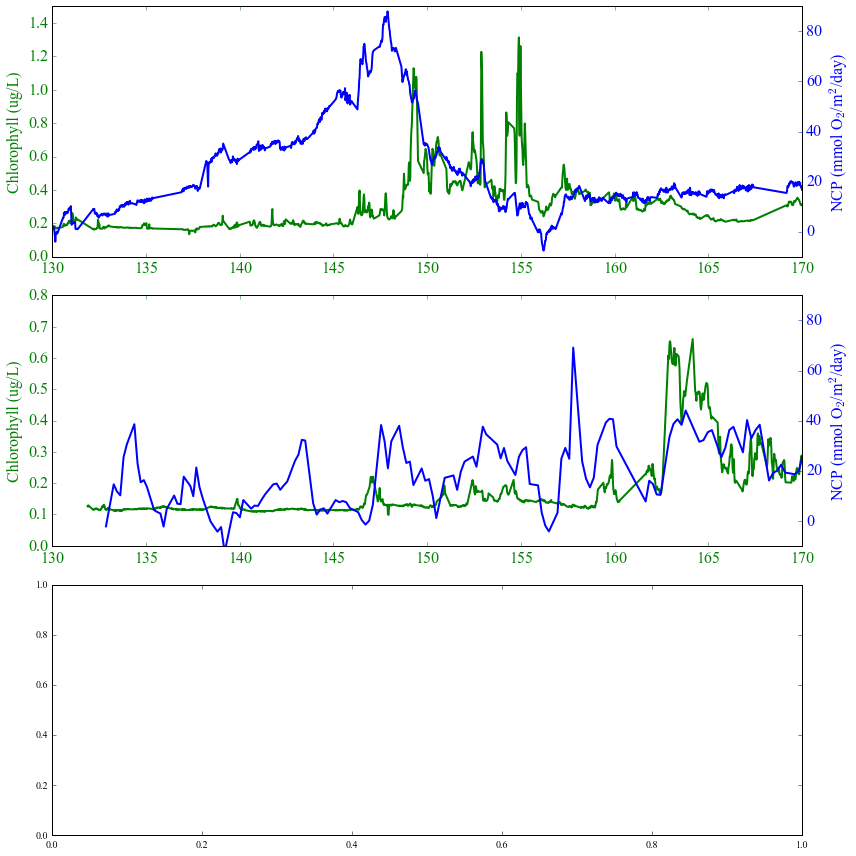

In [10]:
# fig2, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12, 18), dpi = 300)
# fig2, (ax1, ax4) = plt.subplots(2, 1, figsize = (12, 12), dpi = 600)
fig2, (ax1, ax4, ax7) = plt.subplots(3, 1, figsize = (12, 12), dpi = 600)

nn = 2

ax1.plot(Tok1['Lon'], Tok1['chl'], '-g', lw = nn)
ax2 = ax1.twinx()
ax2.plot(Tok1['Lon'], Tok1['Air-sea flux'], '-b', lw = nn)
ax1.set_xlim([130, 170])
ax1.set_ylim([0, 1.5])
ax2.set_ylim([-10, 90])


# ax3 = ax1.twinx()
# ax3.plot(Tok1['Lon'], Tok1['T'], '-r', lw = nn)
# ax3.set_ylim([5,28])
# ax3.set_xlim([130, 170])
# ax3.spines['right'].set_position(('axes', 1.2))

ax1.set_ylabel('Chlorophyll (ug/L)', color='green', fontsize = 16)
ax2.set_ylabel('NCP (mmol O$_2$/m$^{2}$/day)', color= 'blue', fontsize = 16)
ax2.tick_params(colors='b', labelsize = 16)
ax1.tick_params(colors='g', labelsize = 16)


ax4.plot(Tok3['Lon'], Tok3['chl'], '-g', lw = nn)
ax5 = ax4.twinx()
ax5.plot(Tok3f['Lon'], Tok3f['Air-sea flux'], '-b', lw = nn)
ax4.set_xlim([130, 170])
ax4.set_ylim([0, 0.8])
ax5.set_ylim([-10, 90])

# ax6 = ax4.twinx()
# ax6.plot(Tok3['Lon'], Tok3['T'], '-k', lw = nn)
# ax6.set_ylim([10,28])

ax4.set_ylabel('Chlorophyll (ug/L)', color='green', fontsize = 16)
ax5.set_ylabel('NCP (mmol O$_2$/m$^{2}$/day)', color= 'blue', fontsize = 16)
ax5.tick_params(colors='b', labelsize = 16)
ax4.tick_params(colors='g', labelsize = 16)


plt.show()

# fig2.savefig('../manuscript/Figure2.png', dpi = 300)

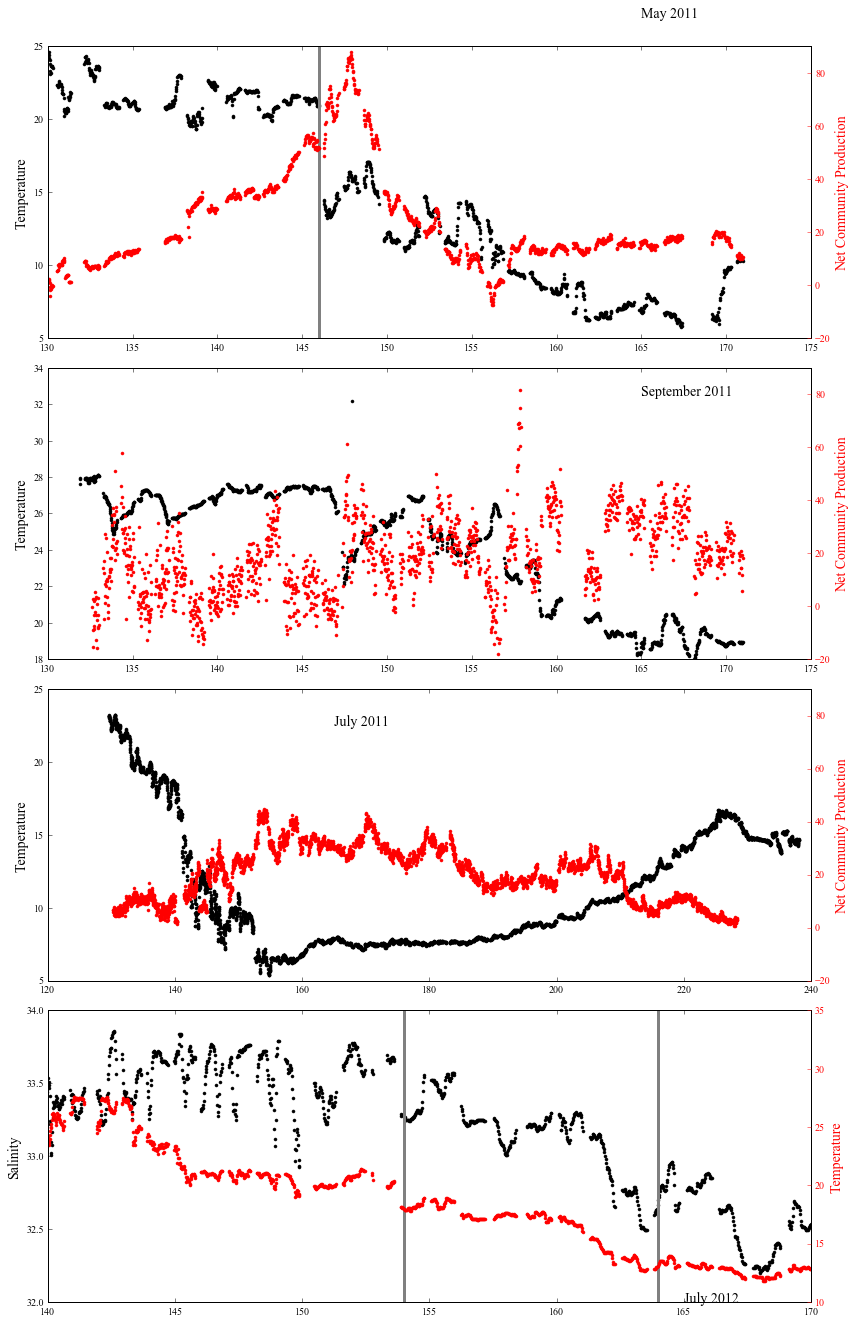

In [11]:
fig2, (ax1, ax2, ax3, ax7) = plt.subplots(4, 1, figsize = (12, 18), dpi = 300)

ax1.plot(Tok1['Lon'], Tok1['T'], '.k')
ax4 = ax1.twinx()
ax4.plot(Tok1['Lon'], Tok1['Air-sea flux'], '.r')
#ax1.set_xlim([140, 170])
#ax1.set_ylim([5, 25])
ax4.set_ylim([-20, 90])
ax1.text(165, 27,'May 2011', fontsize = 14)
ax1.axvline(146, color='grey', lw =3)
ax1.set_ylabel('Temperature', color='k', fontsize = 14)
ax4.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax4.tick_params(colors='r')

ax2.plot(Tok3['Lon'], Tok3['T'], '.k')
ax5 = ax2.twinx()
ax5.plot(Tok3['Lon'], Tok3['Air-sea flux'], '.r')
#ax2.set_xlim([140, 170])
#ax2.set_ylim([15, 30])
ax5.set_ylim([-20, 90])
ax2.text(165, 32.5,'September 2011', fontsize = 14)

ax2.set_ylabel('Temperature', color='k', fontsize = 14)
ax5.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax5.tick_params(colors='r')

ax3.plot(Tok2['Lon'], Tok2['T'], '.k')
ax6 = ax3.twinx()
ax6.plot(Tok2['Lon'], Tok2['Air-sea flux'], '.r')
#ax2.set_xlim([140, 170])
#ax2.set_ylim([15, 30])
ax6.set_ylim([-20, 90])
ax3.text(165, 22.5,'July 2011', fontsize = 14)

ax3.set_ylabel('Temperature', color='k', fontsize = 14)
ax6.set_ylabel('Net Community Production', color= 'r', fontsize = 14)
ax6.tick_params(colors='r')

ax7.plot(Tian['Lon'], Tian['S'], '.k')
ax7.set_xlim([140, 170])
ax8 = ax7.twinx()
ax8.plot(Tian['Lon'], Tian['T'], '.r')

ax7.set_ylim([32, 34])
#ax8.set_ylim([-20, 90])
ax7.text(165, 32,'July 2012', fontsize = 14)
# ax9 = ax7.twinx()
# ax9.plot(Tian['Lon'], Tian['chl'], '.g')
ax8.set_xlim([140, 170])
ax7.set_ylabel('Salinity', color='k', fontsize = 14)
ax8.set_ylabel('Temperature', color= 'r', fontsize = 14)
ax8.tick_params(colors='r')
ax8.set_xlabel('Longitude', fontsize = 14)
ax7.axvline(154, color='grey', lw =3)
ax7.axvline(164, color='grey', lw =3)


plt.show()

#fig2.savefig('../figures/uway_NCP_sst_MJJS.png', dpi = 300)

In [12]:
data = pd.concat([Tok1,  Tian], ignore_index = True)

subset = data 

# bin the nitrate data into sigma vs latitude bins

dy = 0.5
dx = 1.

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 45., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binned = np.empty([len(xbin), len(ybin)])
binnedstd = np.empty([len(xbin), len(ybin)])
fvar = 'chl'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)

        if nn > 0:
            binned[i,j] = np.nanmean(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
            binnedstd[i,j] = np.nanstd(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
        else:
            binned[i,j] = np.nan
            binnedstd[i,j] = np.nan


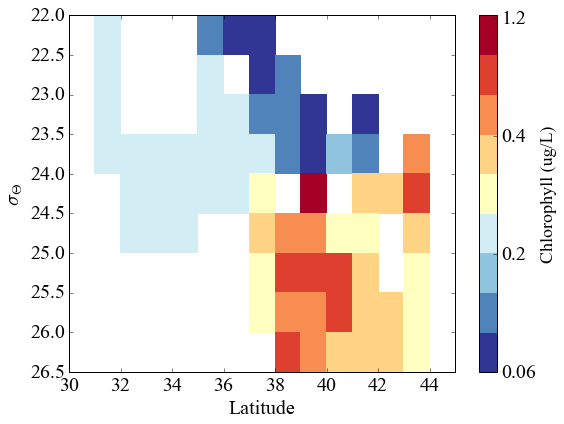

In [13]:
fig1 = plt.figure(1, figsize=(8,6))
#plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)

palette = plt.get_cmap('RdYlBu_r',9)


binned = ma.masked_where(np.isnan(binned), binned)
binnedstd = ma.masked_where(np.isnan(binnedstd), binnedstd)

palette.set_bad('grey')

plt.pcolor(xgrid, ygrid, np.log10(binned), vmin = -1.2, vmax = 0.01, lw=0, cmap = palette)


#plt.contour()
cb = plt.colorbar(ticks = np.arange(-1.2, 0.01, 0.4))
cb.ax.set_yticklabels(['0.06','0.2','0.4','1.2'])
cb.set_label('Chlorophyll (ug/L)', fontsize = 18)
#plt.gca().invert_yaxis()
plt.axis([ 30,45, 26.5, 22.0])

#plt.axhline(23.5, color='grey', lw=2)
#plt.axhline(25, color='grey', lw=2) 

# plt.axvline(33., color='grey', lw=2)
# plt.axvline(38, color='grey', lw=2) 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)


plt.show()

#fig1.savefig('../figures/kuro_chl_binned_allcruises.png', bbox_inches='tight', dpi=600)

number of segments =  14
for total  range
estimated slope for NCP =  -2.19812257829 , r =  -0.98384407176 , p-value < 0.05  True
estimated slope for T =  -3.02460216819 , r =  -0.978816584877 , p-value < 0.05  True
estimated slope for Chl =  -2.71906012903 , r =  -0.936743429922 , p-value < 0.05  True
 
for 20 - 200km range
estimated slope for NCP =  -2.51662848339 , r =  -0.954418900654 , p-value < 0.05  True
estimated slope for T =  -2.6287679042 , r =  -0.983672975883 , p-value < 0.05  True
estimated slope for Chl =  -1.66384187483 , r =  -0.919338678172 , p-value < 0.05  True
 
for 5 - 20km range
estimated slope for NCP =  -1.80833318559 , r =  -0.93115136576 , p-value < 0.05  True
estimated slope for T =  -3.69703820814 , r =  -0.966739632729 , p-value < 0.05  True
estimated slope for Chl =  -4.00561433241 , r =  -0.945581590643 , p-value < 0.05  True


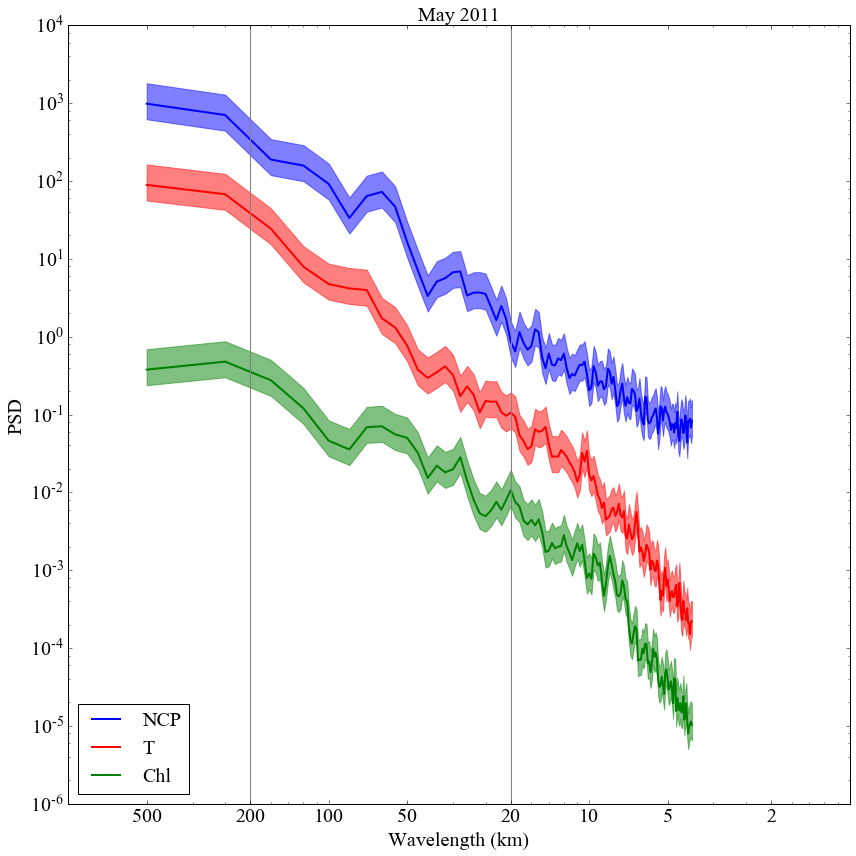

In [14]:
# FFT
M = 500;
dx = 2
# for Tokyo_1 cruise
N = np.max(Tok1['x'].values) - np.min(Tok1['x'].values)
n = 0
ll = 0
Tok1['nx'] = Tok1['x'] - np.min(Tok1['x'].values)

freq = np.fft.fftfreq(M/dx, d=dx)
pgram = np.zeros(len(freq))
pgramT = np.zeros(len(freq))
pgramc = np.zeros(len(freq))


data_int = pd.DataFrame()

data_int['x'] = np.arange(Tok1['nx'][0], Tok1['nx'][len(Tok1)-1], dx)
data_int['NCP'] = np.interp(data_int['x'].values, Tok1['nx'], Tok1['Air-sea flux'])
data_int['T'] = np.interp(data_int['x'].values, Tok1['nx'], Tok1['T'])
data_int['chl'] = np.interp(data_int['x'].values, Tok1['nx'], Tok1['chl'])



while n < (N - M):
    
    data = data_int[(data_int['x']>=n) &(data_int['x']<(n+M))]
    # get linear trend
    m, c, rR, p, std_err = ss.linregress(data['x'], data['NCP'])
    trend = m*data['x'].values + c 
    det_data = data['NCP'].values-trend
    
    mT,cT, rR, p, std_err = ss.linregress(data['x'], data['T'])
    trendT = mT*data['x'].values + cT 
    det_dataT = data['T'].values-trendT
    
    mc,cc, rR, p, std_err = ss.linregress(data['x'], data['chl'])
    trendc = mc*data['x'].values + cc 
    det_datac = data['chl'].values-trendc



    pgram += np.abs(np.fft.fft((det_data)*np.hanning(len(det_data))))**2
    pgramT += np.abs(np.fft.fft((det_dataT)*np.hanning(len(det_dataT))))**2
    pgramc += np.abs(np.fft.fft((det_datac)*np.hanning(len(det_datac))))**2

    
    n += M/2
    ll += 1

pgram = (pgram/len(data_int)*2)[1:125]
pgramT = (pgramT/len(data_int)*2)[1:125]
pgramc = (pgramc/len(data_int)*2)[1:125]

freq = freq[1:125]

nu = 2*(ll)
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(freq, pgram, 'b', lw=2, label='NCP')
plt.fill_between(freq, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(freq, pgramT, 'r', lw=2, label='T')
plt.fill_between(freq, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.plot(freq, pgramc, 'g', lw=2, label='Chl')
plt.fill_between(freq, pgramc*err_low, pgramc*err_high, color='g', alpha = 0.5)

plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('May 2011',fontsize = 20)

print 'number of segments = ',ll

print 'for total  range'

m,c, r, p, std_err = ss.linregress(np.log10(freq),np.log10(pgram))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq),np.log10(pgramT))
mc,cc, rc, pc, std_errc = ss.linregress(np.log10(freq),np.log10(pgramc))


print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05
print 'estimated slope for Chl = ', mc, ', r = ', rc, ', p-value < 0.05 ', pc<0.05
print ' '

print 'for 20 - 200km range'
yy = np.where((1/freq>=20) & (1/freq<=200))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))
mc,cc, rc, pc, std_errc = ss.linregress(np.log10(freq[yy]),np.log10(pgramc[yy]))


print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05
print 'estimated slope for Chl = ', mc, ', r = ', rc, ', p-value < 0.05 ', pc<0.05


print ' '
print 'for 5 - 20km range'
yy = np.where((1/freq>=5) & (1/freq<=20))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))
mc,cc, rc, pc, std_errc = ss.linregress(np.log10(freq[yy]),np.log10(pgramc[yy]))


print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05
print 'estimated slope for Chl = ', mc, ', r = ', rc, ', p-value < 0.05 ', pc<0.05
plt.show()

#fig1.savefig('../figures/NCP_T_FFT_May11.png', bbox_inches='tight', dpi=600)

T1_ncp = pgram
T1_t = pgramT
T1_c = pgramc
T1_err_low = err_low
T1_err_high = err_high

number of segments =  14
for total  range
estimated slope for NCP =  -3.41976436298 , r =  -0.976859490657 , p-value < 0.05  True
estimated slope for T =  -2.41886442665 , r =  -0.980137490393 , p-value < 0.05  True
estimated slope for Chl =  -2.79618230136 , r =  -0.971380698278 , p-value < 0.05  True
 
for 20 - 200km range
estimated slope for NCP =  -2.63890173346 , r =  -0.970783358768 , p-value < 0.05  True
estimated slope for T =  -2.3580608367 , r =  -0.971585392594 , p-value < 0.05  True
estimated slope for Chl =  -2.0545287283 , r =  -0.931094071062 , p-value < 0.05  True
 
for 5 - 20km range
estimated slope for NCP =  -4.48353819551 , r =  -0.973711088572 , p-value < 0.05  True
estimated slope for T =  -2.90712840527 , r =  -0.951755760276 , p-value < 0.05  True
estimated slope for Chl =  -3.22494352503 , r =  -0.928644828545 , p-value < 0.05  True


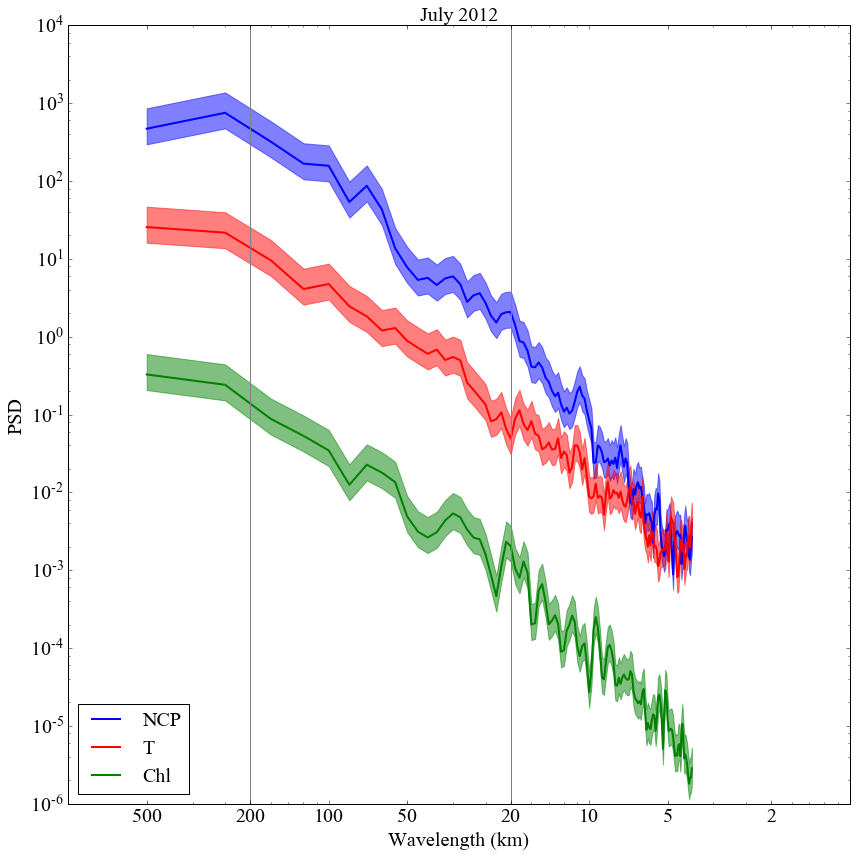

In [15]:
# FFT

# for Tokyo_3 cruise
N = np.max(Tian['x'].values) - np.min(Tian['x'].values)
n = 0
ll = 0
Tian['nx'] = Tian['x'] - np.min(Tian['x'].values)

freq = np.fft.fftfreq(M/dx, d=dx)
pgram = np.zeros(len(freq))
pgramT = np.zeros(len(freq))
pgramc = np.zeros(len(freq))

data_int = pd.DataFrame()

data_int['x'] = np.arange(Tian['nx'][0], Tian['nx'][len(Tian)-1], dx)
data_int['NCP'] = np.interp(data_int['x'].values, Tian['nx'], Tian['Air-sea flux'])
data_int['T'] = np.interp(data_int['x'].values, Tian['nx'], Tian['T'])
data_int['chl'] = np.interp(data_int['x'].values, Tian['nx'], Tian['chl'])


while n < (N - M):
    
    data = data_int[(data_int['x']>=n) &(data_int['x']<(n+M))]
    # get linear trend
    m, c, rR, p, std_err = ss.linregress(data['x'], data['NCP'])
    trend = m*data['x'].values + c 
    det_data = data['NCP'].values-trend
    
    mT,cT, rR, p, std_err = ss.linregress(data['x'], data['T'])
    trendT = mT*data['x'].values + cT 
    det_dataT = data['T'].values-trendT
    
    mc,cc, rR, p, std_err = ss.linregress(data['x'], data['chl'])
    trendc = mc*data['x'].values + cc 
    det_datac = data['chl'].values-trendc


    pgram += np.abs(np.fft.fft((det_data)*np.hanning(len(det_data))))**2
    pgramT += np.abs(np.fft.fft((det_dataT)*np.hanning(len(det_dataT))))**2
    pgramc += np.abs(np.fft.fft((det_datac)*np.hanning(len(det_datac))))**2

    
    n += M/2
    ll += 1

pgram = (pgram/len(data_int)*2)[1:125]
pgramT = (pgramT/len(data_int)*2)[1:125]
pgramc = (pgramc/len(data_int)*2)[1:125]

freq = freq[1:125]

nu = 2*(ll)
err_high = nu/ss.chi2.ppf(0.05/2, nu)
err_low = nu/ss.chi2.ppf(1-0.05/2, nu)


fig1 = plt.figure(3, figsize=(12,12), dpi = 600)

plt.plot(freq, pgram, 'b', lw=2, label='NCP')
plt.fill_between(freq, pgram*err_low, pgram*err_high, color='blue', alpha = 0.5)

plt.plot(freq, pgramT, 'r', lw=2, label='T')
plt.fill_between(freq, pgramT*err_low, pgramT*err_high, color='red', alpha = 0.5)

plt.plot(freq, pgramc, 'g', lw=2, label='Chl')
plt.fill_between(freq, pgramc*err_low, pgramc*err_high, color='green', alpha = 0.5)


plt.legend(loc = 'lower left', fontsize = 20)
plt.tick_params(labelsize=20)

plt.yscale('log')
plt.xscale('log')

plt.ylabel('PSD', fontsize = 20)
plt.xlabel('Wavelength (km)', fontsize = 20)
plt.xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

plt.axvline(1./200, color = 'grey')
plt.axvline(1./20, color = 'grey')


plt.title('July 2012',fontsize = 20)

print 'number of segments = ',ll

print 'for total  range'

m,c, r, p, std_err = ss.linregress(np.log10(freq),np.log10(pgram))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq),np.log10(pgramT))
mc,cc, rc, pc, std_errc = ss.linregress(np.log10(freq),np.log10(pgramc))


print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05
print 'estimated slope for Chl = ', mc, ', r = ', rc, ', p-value < 0.05 ', pc<0.05

print ' '
print 'for 20 - 200km range'
yy = np.where((1/freq>=20) & (1/freq<=200))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))
mc,cc, rc, pc, std_errc = ss.linregress(np.log10(freq[yy]),np.log10(pgramc[yy]))


print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05
print 'estimated slope for Chl = ', mc, ', r = ', rc, ', p-value < 0.05 ', pc<0.05


print ' '
print 'for 5 - 20km range'
yy = np.where((1/freq>=5) & (1/freq<=20))
m,c, r, p, std_err = ss.linregress(np.log10(freq[yy]),np.log10(pgram[yy]))
mT,cT, rT, pT, std_errT = ss.linregress(np.log10(freq[yy]),np.log10(pgramT[yy]))
mc,cc, rc, pc, std_errc = ss.linregress(np.log10(freq[yy]),np.log10(pgramc[yy]))


print 'estimated slope for NCP = ', m, ', r = ', r, ', p-value < 0.05 ', p<0.05
print 'estimated slope for T = ', mT, ', r = ', rT, ', p-value < 0.05 ', pT<0.05
print 'estimated slope for Chl = ', mc, ', r = ', rc, ', p-value < 0.05 ', pc<0.05




plt.show()

#fig1.savefig('../figures/NCP_T_FFT_July12.png', bbox_inches='tight', dpi=600)

Tn_ncp = pgram
Tn_t = pgramT
Tn_c = pgramc

Tn_err_low = err_low
Tn_err_high = err_high

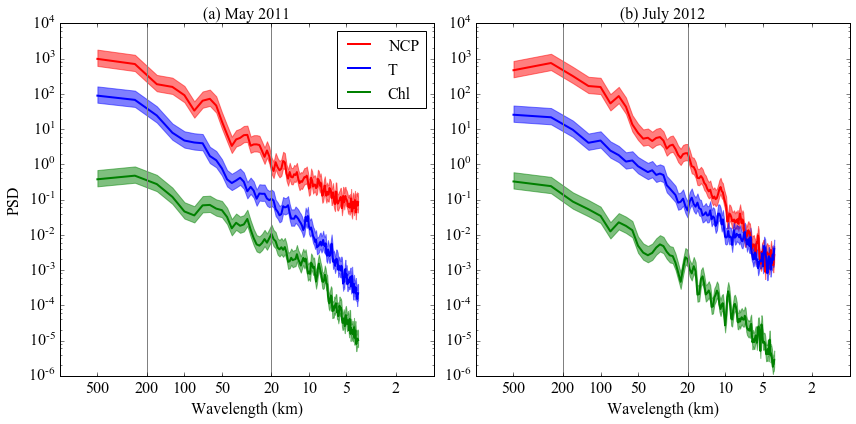

In [16]:
# fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), dpi = 300)
fig2, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)

nn = 16

ax1.plot(freq, T1_ncp, 'r', lw=2, label='NCP')
ax1.fill_between(freq, T1_ncp*T1_err_low, T1_ncp*T1_err_high, color='r', alpha = 0.5)

ax1.plot(freq, T1_t, 'b', lw=2, label='T')
ax1.fill_between(freq, T1_t*T1_err_low, T1_t*T1_err_high, color='b', alpha = 0.5)

ax1.plot(freq, T1_c, 'g', lw=2, label='Chl')
ax1.fill_between(freq, T1_c*T1_err_low, T1_c*T1_err_high, color='g', alpha = 0.5)

ax1.legend(loc = 'upper right', fontsize = nn)
ax1.tick_params(labelsize=nn)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([10**-6, 10**4])


ax1.set_ylabel('PSD', fontsize = nn)
ax1.set_xlabel('Wavelength (km)', fontsize = nn)
ax1.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

ax1.axvline(1./200, color = 'grey')
ax1.axvline(1./20, color = 'grey')
ax1.set_title('(a) May 2011', fontsize = nn)
ax1.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]))
ax1.set_xticklabels([500, 200, 100, 50, 20, 10, 5, 2])

######################################################################################################################

# ax2.plot(freq, T3_ncp, 'b', lw=2, label='NCP')
# ax2.fill_between(freq, T3_ncp*T3_err_low, T3_ncp*T3_err_high, color='blue', alpha = 0.5)

# ax2.plot(freq, T3_t, 'r', lw=2, label='T')
# ax2.fill_between(freq, T3_t*T3_err_low, T3_t*T3_err_high, color='red', alpha = 0.5)

# ax2.tick_params(labelsize=16)

# ax2.set_yscale('log')
# ax2.set_xscale('log')
# ax2.set_ylim([10**-5, 10**5])

# ax2.set_xlabel('Wavelength (km)', fontsize = 16)
# ax2.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

# ax2.axvline(1./200, color = 'grey')
# ax2.axvline(1./20, color = 'grey')
# ax2.set_title('September 2011', fontsize = 16)
# ax2.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]))
# ax2.set_xticklabels([500, 200, 100, 50, 20, 10, 5, 2])

######################################################################################################################

ax3.plot(freq, Tn_ncp, 'r', lw=2, label='NCP')
ax3.fill_between(freq, Tn_ncp*Tn_err_low, Tn_ncp*Tn_err_high, color='r', alpha = 0.5)

ax3.plot(freq, Tn_t, 'b', lw=2, label='T')
ax3.fill_between(freq, Tn_t*Tn_err_low, Tn_t*Tn_err_high, color='b', alpha = 0.5)

ax3.plot(freq, Tn_c, 'g', lw=2, label='Chl')
ax3.fill_between(freq, Tn_c*Tn_err_low, Tn_c*Tn_err_high, color='g', alpha = 0.5)

ax3.tick_params(labelsize=nn)

ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([10**-6, 10**4])


ax3.set_xlabel('Wavelength (km)', fontsize = nn)
ax3.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]), [500, 200, 100, 50, 20, 10, 5, 2])

ax3.axvline(1./200, color = 'grey')
ax3.axvline(1./20, color = 'grey')
ax3.set_title('(b) July 2012', fontsize = nn)
ax3.set_xticks(1./np.array([500, 200, 100, 50, 20, 10, 5, 2]))
ax3.set_xticklabels([500, 200, 100, 50, 20, 10, 5, 2])

plt.show()

# fig2.savefig('../manuscript/Figure7.png', dpi = 300)